# Test MCS with Softmax Regression

This is a notebook for testing MCS with softmax regression

## Import everything

modify setting for pytorch

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

import torch and other standard modules

In [2]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import time
from matplotlib.ticker import FormatStrFormatter

#d2l.use_svg_display()

import MCS and CostFunc

In [3]:
from Optimizers import MCSOptimizer
from CostFunc import GradFreeCrossEntropyLoss
from CostFunc import StandardSNN

## Softmax Regression Testing

### Reading data Fashion-MNIST

In [4]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

In [5]:
print(len(mnist_train), len(mnist_test))
print(mnist_train[0][0].shape)

60000 10000
torch.Size([1, 28, 28])


In [6]:
def get_fashion_mnist_labels(labels):  
    """return text labels"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [7]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  
    """draw the images"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

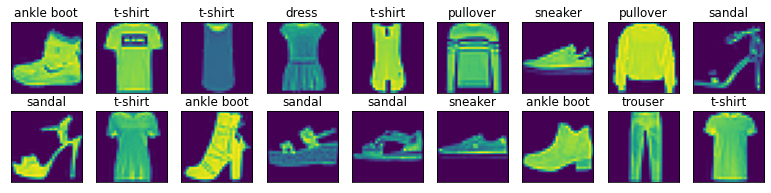

In [8]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

### Reading small batches

In [9]:
batch_size = 256

def get_dataloader_workers():  #@save
    """using 4 workers"""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())

In [10]:
class Timer:
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

In [11]:
timer = Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'4.11 sec'

### Reading the data via torch API

In [12]:
def load_data_fashion_mnist(batch_size, resize=None):  
    """generate the data_iter"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [13]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)
X,y=next(iter(train_iter))
print(X.shape, X.dtype, y.shape, y.dtype)
X,y=next(iter(test_iter))
print(X.shape, X.dtype, y.shape, y.dtype)

torch.Size([256, 1, 28, 28]) torch.float32 torch.Size([256]) torch.int64
torch.Size([256, 1, 28, 28]) torch.float32 torch.Size([256]) torch.int64


## Define a model

### Function for initialize weight function

In [14]:
num_inputs = 784
num_outputs = 10

In [15]:
def getParams(num_inputs,num_outputs):
    W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
    b = torch.normal(0,0.1,size=(num_outputs,), requires_grad=True)
    return (W,b)

### Softmax Net Model

In [16]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition 

In [17]:
class SoftmaxNet(StandardSNN):
    '''a standard net with linear regression'''
    def __init__(self,getParams,num_inputs,num_outputs):
        self.params=getParams(num_inputs,num_outputs)

    def __call__(self,X:torch.Tensor):
        return self.call_with_weight(X,self.params)

    def call_with_weight(self,X:torch.Tensor,weight:tuple):
        W,b=weight
        return torch.matmul(X.reshape((-1, W.shape[0])),W)+b

In [18]:
net=SoftmaxNet(getParams,num_inputs,num_outputs)
rawParams=()
for param in net.params:
    rawParams+=(param.clone().detach().requires_grad_(True),)
#print(net.params)
#print(rawParams)

## Classification Accuracy

In [19]:
def accuracy(y_hat, y): 
    """calculate the number of correct classification"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [20]:
def evaluate_accuracy(net, data_iter):  
    """calculate the accuracy for the whole dataset"""
    if isinstance(net, torch.nn.Module):
        net.eval() 
    metric = Accumulator(2) 
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [21]:
class Accumulator:  #@save
    """accumulate on n variables"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [22]:
evaluate_accuracy(net, test_iter)

0.1009

## Predictor

In [23]:
def predict(net, test_iter, n=6): 
    """predict the label"""
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(softmax(net(X)).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

## Train a model

### Set epochs

In [24]:
num_epochs=10

### Loss function

In [25]:
lossFunc=GradFreeCrossEntropyLoss(net)

### Animation for training

In [26]:
class Animator:  
    """drawing data with animation"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # draw grids
        if legend is None:
            legend = []
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # define paramters catcher
        self.config_axes = lambda: self.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
    
    def set_axes(self,axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """Set the axes for matplotlib."""
        axes.set_xlabel(xlabel)
        axes.set_ylabel(ylabel)
        axes.set_xscale(xscale)
        axes.set_yscale(yscale)
        axes.set_xlim(xlim)
        axes.set_ylim(ylim)
        if legend:
            axes.legend(legend)
        axes.grid()

    def add(self, x, y):
        # add data point
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

### MCS optimizer

In [27]:
mcs=MCSOptimizer(net.params,lossFunc,train_iter,\
    maxLevyStepSize=[1,0.5],randInit=True,nestNum=40)

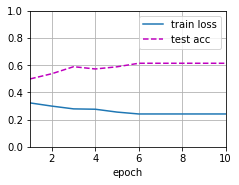

In [28]:
acc_epochs_mcs=[evaluate_accuracy(net,test_iter)]
#print(f'epoch 0, test acc {acc_epochs_mcs[0]:f}')
animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                        legend=['train loss', 'test acc'])
for epoch in range(num_epochs):
    with torch.no_grad():
        train_loss, train_momentum_loss=mcs.step()
        train_loss=train_loss
        test_acc = evaluate_accuracy(net,test_iter)
        acc_epochs_mcs.append(test_acc)
        animator.add(epoch + 1, (train_loss/5.0,test_acc))
        #print(f'epoch {epoch + 1}, test acc {acc_epochs_mcs[epoch+1]:f}')

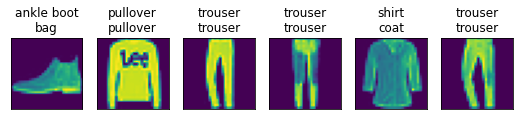

In [29]:
predict(net, test_iter)

### Standard sgd

In [30]:
net.params=rawParams
#print(net.params)

In [31]:
trainer = torch.optim.SGD(net.params, lr=0.1)

In [32]:
def train_epoch(net, train_iter, loss, updater):  
    """train a epoch"""
    # set to train mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # train metric
    metric = Accumulator(3)
    batch_num=0
    for X, y in train_iter:
        batch_num+=1
        # calculate gradients
        y_hat = net(X)
        l = loss(y_hat, y)
        updater.zero_grad()
        l.backward()
        updater.step()
        metric.add(float(l), accuracy(y_hat, y), y.numel())
    # return train_loss and train_acc
    return metric[0]/batch_num, metric[1] / metric[2]

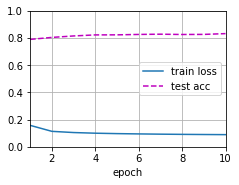

In [33]:
acc_epochs_sgd=[evaluate_accuracy(net,test_iter)]
animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                        legend=['train loss', 'test acc'])
for epoch in range(num_epochs):
    (train_loss, train_acc) = train_epoch(net, train_iter, lossFunc, trainer)
    test_acc = evaluate_accuracy(net, test_iter)
    animator.add(epoch + 1, (train_loss/5.0,test_acc))
    acc_epochs_sgd.append(test_acc)

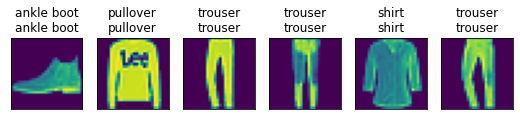

In [34]:
predict(net, test_iter)

## Visualize the Result

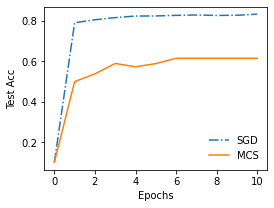

In [35]:
fig, axes = plt.subplots(1, 1, figsize=(4,3))

axes.plot(range(0,num_epochs+1),acc_epochs_sgd,linestyle='-.',label='SGD')
axes.plot(range(0,num_epochs+1),acc_epochs_mcs,linestyle='-',label='MCS')


axes.set_xlabel('Epochs')
axes.set_ylabel('Test Acc')

axes.xaxis.set_major_formatter(FormatStrFormatter('%d'))

axes.legend(loc=0,frameon=False);